In [41]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot,draw_correlation_scatter
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
import seaborn as sns
import random
from scipy.stats import pearsonr

from pop_organize import get_sample_data, get_sample_with_dfs
from SufficientStatistics import *
from MyFunctionsShani import *


In [42]:
import time
cdate=str(time.strftime("%d%m%Y"))
cdate

'26112017'

# loading data and generating general descriptive statistics

In [43]:
# download QC information together with all other samples:
file1= '/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/QC/qcReport_11-22-2017_combined.xlsx'
qcReport=pd.read_excel(file1)
qcReport=qcReport.set_index('Sample Name')

In [44]:
for n in qcReport.index:
    if 'IZTR' in n:
        qcReport.loc[n,'Group']='bulkTILs_nov17'
        

In [45]:
#add sample_overview information:
file2= '/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/QC/SampleOverview_11-22-2017_combined.xlsx'
SampleOverview=pd.read_excel(file2)
SampleOverview.set_index('sample_name', inplace=True)

In [46]:
SampleOverviewAndQC=pd.merge(SampleOverview,qcReport,how='left', left_index=True, right_index=True)

In [47]:
columns_QC=['Coverage', '% On-target','putative n reads']
columns_samplesOverview=['total_templates','total_rearrangements','fraction_productive','max_frequency','sample_clonality',
                         'sample_entropy', 'productive_clonality','productive_entropy']

In [48]:
SampleOverviewAndQC_nulkTILs_nov17=SampleOverviewAndQC[SampleOverviewAndQC['Group']=='bulkTILs_nov17']

In [51]:
SampleOverviewAndQC_nulkTILs_nov17.drop(['Well Location','Date Posted','Run ID','Kit UID','Group','total_reads'],axis=1)

,total_templates,fraction_productive,total_rearrangements,productive_rearrangements,productive_clonality,max_productive_frequency,outofframe_rearrangements,stop_rearrangements,outofframe_templates,stop_templates,sample_clonality,sample_entropy,productive_entropy,max_frequency,Gene Rearrangements,Coverage,% On-target,QC Status,putative n reads
sample_name,,,,,,,,,,,,,,,,,,,
IZTR_32_2,39330,0.6989,246,163,0.6352,36.774710,72,11,11821,20,0.6404,2.8565,2.6810,29.160947,39330,16.6,24.855995,PASS,652878.0
IZTR_32_1,40197,0.7058,248,173,0.6347,33.543634,68,7,11814,11,0.6370,2.8875,2.7162,28.489688,40197,16.9,25.427740,PASS,679329.3
IZTR_12_2,16078,0.7089,175,109,0.6126,37.366206,60,6,4672,8,0.6182,2.8451,2.6221,28.025874,16078,25.8,20.426892,PASS,414812.4
IZTR_12_1,16952,0.7020,160,96,0.6004,35.627258,61,3,5046,5,0.6124,2.8379,2.6316,28.745872,16952,22.7,20.214069,PASS,384810.4


In [49]:
SampleOverviewAndQC_nulkTILs_nov17.describe()

,total_templates,fraction_productive,total_rearrangements,productive_rearrangements,productive_clonality,max_productive_frequency,outofframe_rearrangements,stop_rearrangements,outofframe_templates,stop_templates,sample_clonality,sample_entropy,productive_entropy,max_frequency,Kit UID,Gene Rearrangements,Coverage,% On-target,putative n reads
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.0,4.000000,4.000000,4.000000,4.000000
mean,28139.250000,0.703900,207.250000,135.250000,0.620725,35.827952,65.250000,6.750000,8338.250000,11.000000,0.627000,2.856750,2.662725,28.605595,322985.0,28139.250000,20.500000,22.731174,532957.525000
std,13431.933774,0.004367,46.313245,38.404644,0.017165,1.685325,5.737305,3.304038,4020.393213,6.480741,0.013786,0.021884,0.044018,0.475256,0.0,13431.933774,4.512944,2.794749,154608.600502
min,16078.000000,0.698900,160.000000,96.000000,0.600400,33.543634,60.000000,3.000000,4672.000000,5.000000,0.612400,2.837900,2.622100,28.025874,322985.0,16078.000000,16.600000,20.214069,384810.400000
25%,16733.500000,0.701225,171.250000,105.750000,0.609550,35.106352,60.750000,5.250000,4952.500000,7.250000,0.616750,2.843300,2.629225,28.373735,322985.0,16733.500000,16.825000,20.373686,407311.900000
50%,28141.000000,0.703900,210.500000,136.000000,0.623650,36.200984,64.500000,6.500000,8430.000000,9.500000,0.627600,2.850800,2.656300,28.617780,322985.0,28141.000000,19.800000,22.641444,533845.200000
75%,39546.750000,0.706575,246.500000,165.500000,0.634825,36.922584,69.000000,8.000000,11815.750000,13.250000,0.637850,2.864250,2.689800,28.849641,322985.0,39546.750000,23.475000,24.998931,659490.825000
max,40197.000000,0.708900,248.000000,173.000000,0.635200,37.366206,72.000000,11.000000,11821.000000,20.000000,0.640400,2.887500,2.716200,29.160947,322985.0,40197.000000,25.800000,25.427740,679329.300000


In [52]:
file1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/SamuelsSamples/Samuels_analysis/SampleOverviewAndQC_nulkTILs_nov17'
SampleOverviewAndQC_nulkTILs_nov17.to_pickle(file1)

file2='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/SamuelsSamples/Samuels_analysis/SampleOverviewAndQC_nulkTILs_nov17.xlsx'
SampleOverviewAndQC_nulkTILs_nov17.to_excel(file2)



# rarefaction graphs:

In [57]:
# the following functions were copied from the notebook: "RealData Analysis":

def rarefaction_calc(sample_name, df_list, column_name,sampling_interval):
    
    print ('rarefaction analysis for sample %s' %sample_name)

    n=0
    all_data=[]
    all_seqs=[]
    all_seq_popped=[]
    popped_list_lengths=[]
    '''
    the following loop generate three lists:
    (1) all_seqs list=contains lists of all uniqe sequences in each df contains within the df_list.
    (2) all_data list=contains lists of reads/templates number for each sequence in the all_seq_list
    (3) all_seq_popped list=contains list of popped squences lists, in which each sequence appears the number
    of times indicated by the number of reads/ template
    ***** note that each of the  lists is mata-list containing n lists of the data*******
    '''
    for n in range(len(df_list)):
#         print n
        data=list(df_list[n][column_name])
        df_list[n]=df_list[n].set_index('nucleotide')
        seq=[str(i) for i in list(df_list[n].index)]
        all_data.append(data)
        all_seqs.append(seq)
        seq_popped=[]
        for i in range(0,len(seq)):
            for j in range(0,data[i]):
                seq_popped.append(seq[i])        
        all_seq_popped.append(seq_popped)
        popped_list_lengths.append(len(seq_popped)) 
#         print 'popped_list_lengths=%s' %popped_list_lengths
        n=n+1
     
     
    max_samp_size=max(popped_list_lengths)
#     print('the maximal sample size will be: %s' %max_samp_size)
    samp_size=range(0,max_samp_size,sampling_interval)
#     print'samp_size=%s' %samp_size
        
    n=0
    n_samp_seq_all=[]
    last_values=[]
    for popped in all_seq_popped:
        n_samp_seq=[]
        for size in samp_size:
            if size<=len(popped): ## if the sample size is larger than the amount of
                                  ## sequences in the sample, do not employ random sampling
                rand_seq=np.random.choice(popped, size, replace=False)
                seq_n=len(set(rand_seq))
                n_samp_seq.append(seq_n)
            else:
                n_samp_seq.append(np.nan)
 ##since it is time consuming to generate theses lists, save them as pickles and next time load the pickles
## (comment/uncomment each of the next couple of lines:):          
        pickle.dump(n_samp_seq, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/n_samp_seq_%s_%s.p' %(n, sample_name),"wb" ))
        n_samp_seq_all.append(pickle.load( open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/n_samp_seq_%s_%s.p' %(n, sample_name),"rb" )))
        last_values.append(n_samp_seq[-1])
        
        n=n+1
    last_values=[x for x in last_values if str(x) != 'nan']
    ymax_rare=max(last_values)
#     print('last values list is %s' %last_values)
#     print('ymax for rarefaction plot is %s' %ymax_rare)
#     print ('finished rarefaction analysis for sample %s...' %sample_name)
   
    return samp_size,max_samp_size, n_samp_seq_all, ymax_rare      

#------------------------------------------------------------------------------------------------------------




   
def rarefaction_plot(ax, sample_name, data, names, colors, samp_size, max_samp_size,ymax_rare):
    '''
    this function generates rarefaction graphs for one or more datasets at the same time.
    the datasets can be generated by the function rarefaction_calc. 
    *** the data is a meta-list that can contains several lists of rarefaction values, but they must be generated
    using the same samp_size list***
    input:
    sample_name
    data - see above (the udea is that in each sample size, the list of all sequences in the sample 
    is randomly samples, and the number of unique clones sampled is indicated).
    names corresponding names for the lists in 'data' rarefaction graphs.
    ***need to insert at least name1*** 
    colors: corresponding names for the lists in 'data' rarefaction graphs.
    ***need to insert at least color1***
    samp_size: list of increasing sample sizes, corresponding to the values in the data sets
    max_samp_size: the length of the shorter list among the dataset
    y_max - the maximal value in all data sets together
    ax - the number of subplot in the original image   
    '''
    
    
    print 'plotting rarefaction graphs'
    if ax is None:
        ax = plt.gca()
    curves=[]
    for i in range(len(data)):
        curve=ax.plot(samp_size,data[i],label=names[i],color=colors[i])
        curves.append(curve)
  
   # ax.set_title('%s' %sample, fontsize=12)
    ax.set_xlabel('Sample Size',fontsize=9)
    ax.set_ylabel('Number of unique sequences',fontsize=9)
    fold=np.log10(max_samp_size)
    fold_floor=int(math.floor(fold))
    xticks=range(0,roundup(max_samp_size,10**fold_floor)+10**fold_floor,10**fold_floor)
    yticks=range(0,roundup(ymax_rare,10000)+10000,10000)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticks, rotation=45, fontsize=8)
    ax.set_yticklabels(yticks, fontsize=8)
    ax.legend(loc='best')
    ax.set_xlim(0, roundup(max_samp_size,10000))
    #ax.set_ylim(0, roundup(ymax_rare,10000))
    print 'Finished plotting rarefaction graphs'
    return curves

#-------------------------------------------------------------------------------------------------

def rarefaction_plot_zoom(ax, sample_name, data, names, colors, samp_size, max_samp_size,ymax_rare,xmax,ymax):
    '''
    this function generates rarefaction graphs for one or more datasets at the same time.
    the datasets can be generated by the function rarefaction_calc. 
    *** the data is a meta-list that can contains several lists of rarefaction values, but they must be generated
    using the same samp_size list***
    input:
    sample_name
    data - see above (the udea is that in each sample size, the list of all sequences in the sample 
    is randomly samples, and the number of unique clones sampled is indicated).
    names corresponding names for the lists in 'data' rarefaction graphs.
    ***need to insert at least name1*** 
    colors: corresponding names for the lists in 'data' rarefaction graphs.
    ***need to insert at least color1***
    samp_size: list of increasing sample sizes, corresponding to the values in the data sets
    max_samp_size: the length of the shorter list among the dataset
    y_max - the maximal value in all data sets together
    ax - the number of subplot in the original image   
    '''
    
    
    print 'plotting rarefaction graphs'
    if ax is None:
        ax = plt.gca()
    curves=[]
    for i in range(len(data)):
        curve=ax.plot(samp_size,data[i],label=names[i],color=colors[i])
        curves.append(curve)
  
    ax.set_title('%s' %sample, fontsize=12)
    ax.set_xlabel('Sample Size',fontsize=9)
    ax.set_ylabel('Number of unique sequences',fontsize=9)
    fold=np.log10(max_samp_size)
    fold_floor=int(math.floor(fold))
    xticks=range(0,roundup(max_samp_size,10**fold_floor)+10**fold_floor,10**fold_floor)
    yticks=range(0,roundup(ymax_rare,10000)+10000,10000)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticks, rotation=45, fontsize=8)
    ax.set_yticklabels(yticks, fontsize=8)
    #ax.legend(loc='best')
    ax.set_xlim(xmax-10000, xmax)
    ax.set_ylim(ymax-10000, ymax)
    print 'Finished plotting rarefaction graphs'
    return curves

rarefaction analysis for sample many samples
plotting rarefaction graphs
Finished plotting rarefaction graphs


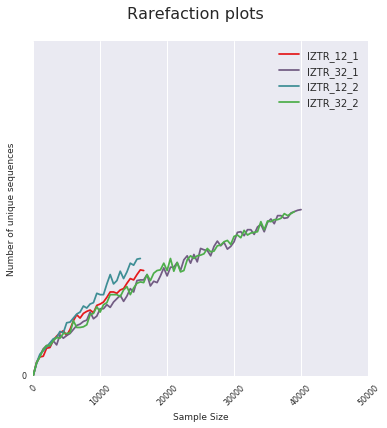

In [61]:
import math
fig,ax=plt.subplots(figsize=(6,6))
                    
plt.suptitle ('Rarefaction plots', fontsize=16)
sample_list=['IZTR_12_1','IZTR_32_1','IZTR_12_2','IZTR_32_2']
dfList=[]
color_list = plt.cm.Set1(np.linspace(0, 1, 13))
for n,sample in enumerate(sample_list): 
    if 'IZTR' in sample:
        df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/SamuelsSamples/SamplesForAnalysis/%s.tsv" % sample)
    else:
        df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/SamplesForAnalysis/%s.tsv" % sample)
    
    df=df.rename(columns={'count (templates/reads)':'count (templates)'})
    dfList.append(df)
samp_size,max_samp_size, n_samp_seq_all, ymax_rare=rarefaction_calc('many samples', dfList,column_name='count (templates)',sampling_interval=500)   
   
rarefaction_plot(ax, sample_name='www', data=n_samp_seq_all, names=sample_list, colors=color_list, samp_size=samp_size, 
                      max_samp_size=max_samp_size,ymax_rare=ymax_rare)
ax.set_ylim(0,500)
#plt.subplots_adjust(left=0.09,bottom=0.11, right=0.95, top=0.89, wspace=0.28,hspace=0.43)
filename='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/SamuelsSamples/Samuels_analysis/rarefactionPlots_%s' %cdate
fig.savefig(filename, bbox_inches='tight', dpi = 200)
plt.show()

# duplicate analysis:

In [77]:
#************ this function is originally from the notebook: Our Data-analysis by run.ipynb **********************

'''
This function generates scatter plot comparing the seq frequencies of two samples. sequences can be nucleotides (seqType-'nt;) 
or aminoacid (seqType='aa'). the scatter plot can be colored using a specified color (color='blue', 'red' etc) or by density 
(color='density'). sequences that appear in one sample but not in the other are indicated with seq freq that is lower than the 
minimum real frequency in the datasets. 
pearson correlation r and p are also calculated, and the percent of sequences overlapping between sequences. 

this function was copied to 'MyFunctionsShani.py'

input:
*sample_name1, sample_name2 - names of samples to compare
*seqType: 'nt' or 'aa'
*color= 'density' for density map, any other legitimate color for uniform color
*ax
'''

def sample_dup_analysis(sample_name1, sample_name2,seqType,color,ax=None):
    from scipy.stats import gaussian_kde
    fig = plt.figure()
    if ax==None:
        fig,ax=plt.subplots()

    if 'IZTR' in sample_name1:
        df1=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/SamuelsSamples/SamplesForAnalysis/%s.tsv" %sample_name1)
    else:
        df1=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/SamplesForAnalysis/%s.tsv" %sample_name1)
    if 'IZTR' in sample_name2:
        df2=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/SamuelsSamples/SamplesForAnalysis/%s.tsv" %sample_name2)
    else:
        df2=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/SamplesForAnalysis/%s.tsv" %sample_name2)
    
    column1='%s frequencyCount (perc)' %sample_name1
    column2='%s frequencyCount (perc)' %sample_name2

    if seqType=='nt':
        df1nt=df1[['nucleotide','frequencyCount (%)']]
        df1nt=df1nt.set_index('nucleotide')
        df1nt=df1nt.rename(columns={'frequencyCount (%)':column1})
        df2nt=df2[['nucleotide','frequencyCount (%)']]
        df2nt=df2nt.set_index('nucleotide')
        df2nt=df2nt.rename(columns={'frequencyCount (%)':column2})
        df1df2=pd.merge(df1nt, df2nt, how='outer', left_index=True, right_index=True)
        
    elif seqType=='aa':
        print 'aa'
        df1=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/%s.tsv" %sample_name1)
        df1aa=df1[['aminoAcid','frequencyCount (%)']]
        df1aagrouped=pd.DataFrame(df1.groupby('aminoAcid')['frequencyCount (%)'].sum())
        df1aagrouped=df1aagrouped.rename(columns={'frequencyCount (%)':column1})
        df2=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/%s.tsv" %sample_name2)
        df2aa=df2[['aminoAcid','frequencyCount (%)']]
        df2aagrouped=pd.DataFrame(df2.groupby('aminoAcid')['frequencyCount (%)'].sum())
        df2aagrouped=df2aagrouped.rename(columns={'frequencyCount (%)':column2})

        df1df2=pd.merge(df1aagrouped, df2aagrouped, how='outer', left_index=True, right_index=True)

   
    data1=df1df2[column1]
    data2=df1df2[column2]
    
    min_freq=min(data1.min(),data2.min())
    dist = int(math.log10(abs(min_freq)))-1 #calculates the number od zeros after the decimal point in the min_freq value

    n_total_seqs=len(df1df2)
    
    n_overlap=len(df1df2[(df1df2[column1].notnull())&(df1df2[column2].notnull())])
    perc_overlap=round(float(n_overlap)*100/n_total_seqs,2)

   
    data1=data1.fillna(10**dist)
    data2=data2.fillna(10**dist)

    if ax==None:
        fig,ax=plt.subplots()

    if color=='density':
        # Calculate the point density
        xy = np.vstack([data1,data2])
        z = gaussian_kde(xy)(xy)
        cmap=plt.cm.gist_rainbow
        c=z
        bestfitColor='grey'
    else:
        c=color
        cmap=plt.cm.nipy_spectral
        bestfitColor=color
        

    ax.scatter(data1, data2, c=c, cmap=cmap,  alpha=0.2)


    ticks=np.logspace(dist-1,0,-(dist-2))#generates the x,y ticks based on the min_freq. the lower tick is used only for margin purposes and the second tick is used as '0'
    labels=[]  # generates the x,y ticklabels based on the ticks
    for i in range(0,len(ticks)):
        if i==0:
            labels.append('')
        elif i==1:
            labels.append('0')
        else:
            labels.append(str(ticks[i]))

    ax.set_xscale('log')
    ax.set_yscale('log')       
    ax.set_xticks(ticks,minor=False)
    ax.set_yticks(ticks,minor=False)
    ax.set_xticklabels(labels,fontsize=10)
    ax.set_yticklabels(labels,fontsize=10)
    ax.set_xlim(5*10**(dist-1),1)
    ax.set_ylim(5*10**(dist-1),1)
#     ax.set_title('NT Sequences Frequency Correlation',fontsize=12)
    ax.set_xlabel(column1 ,fontsize=12)
    ax.set_ylabel(column2,fontsize=12)
    ax.margins(0.2,0.2)
   
#     ax.set_aspect('equal', adjustable='box')
#     cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
#     ax.add_colormap(cax, cmap=cmap)
    
    
#    
    r,p=MyPearsonr(data1,data2)

    #get locations for p-value text
    ylim=ax.get_ylim()
    ypos=ylim[1]
    xlim=ax.get_xlim()
    xpos=xlim[0]
    print xpos, ypos
    ax.text(xpos,ypos,"r=%.3f p=%.2f, perc overlap=%.2f" % (r, p,perc_overlap),  verticalalignment = 'top', ha = 'left',fontsize=12,color='red')
    

    #plot bestfit and identity curves:
    
    ax.plot(np.unique(data1), np.poly1d(np.polyfit(data1, data2, 1))(np.unique(data1)),c=bestfitColor)
    ax.plot(data1,data1,color='black')
    
    
#     filename='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/QC/dup_comparison_%s_%s_%s_%s' %(sample_name1,sample_name2,seqType,color)
#     fig.savefig(filename=filename, dpi=200)
    print sample_name1, sample_name2
    
    
    ## generate summarizing df:
    summaryDF=pd.DataFrame()
    summaryDF.loc[1,'Sample1']=sample_name1
    summaryDF.loc[1,'Sample2']=sample_name2
    summaryDF.loc[1,'seqType']=seqType
    summaryDF.loc[1,'r']=r
    summaryDF.loc[1,'p']=p
    summaryDF.loc[1,'perc_overlap']=perc_overlap
    
    df_file='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/QC/dup analysis dfs/dup_comparison_%s_%s_%s' %(sample_name1,sample_name2,seqType)
    summaryDF.to_pickle(df_file)
    
    
    return r,p, ax,fig



0.0005 1.0
IZTR_12_1 IZTR_12_2
0.0005 1.0
IZTR_32_1 IZTR_32_2
0.0005 1.0
IZTR_32_1 IZTR_12_1
0.0005 1.0
IZTR_32_2 IZTR_12_2


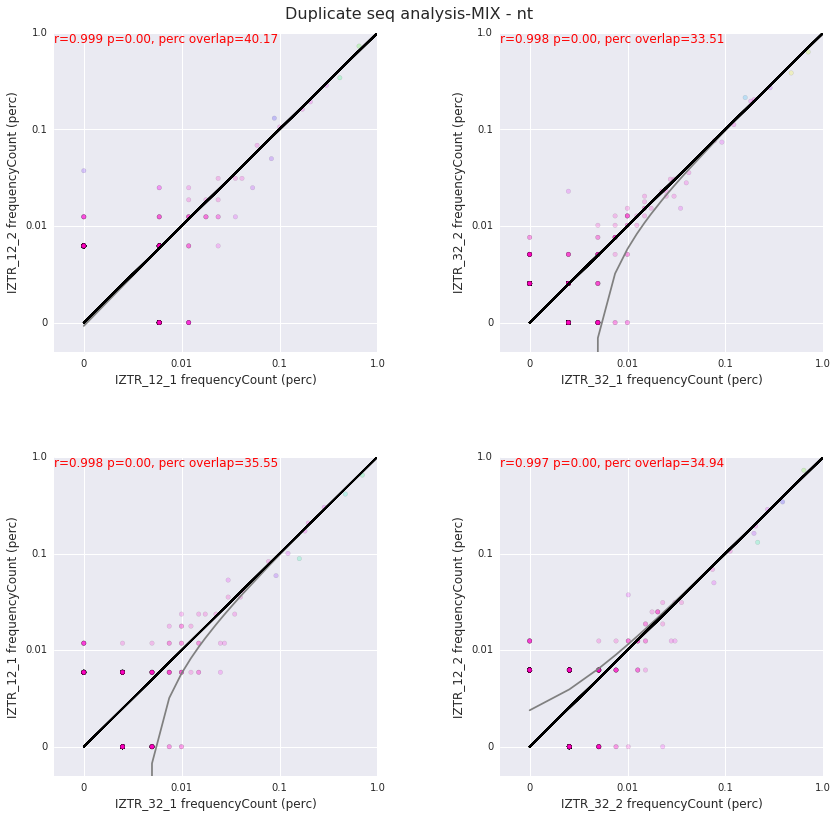

In [78]:
seqType='nt'
color='density'


fig1, ((ax1, ax2),(ax3,ax4))= plt.subplots(nrows=2,ncols=2, figsize=(12,12),sharex=False, sharey=False)
fig1.suptitle('Duplicate seq analysis-MIX - %s' %seqType, fontsize=16)

sample_dup_analysis('IZTR_12_1','IZTR_12_2', seqType, color,ax1)
sample_dup_analysis('IZTR_32_1','IZTR_32_2', seqType, color, ax2)

sample_dup_analysis('IZTR_32_1','IZTR_12_1', seqType, color, ax3)
sample_dup_analysis('IZTR_32_2','IZTR_12_2', seqType, color, ax4)


fig1.subplots_adjust(left=0.09, right=0.98, top=0.95, bottom=0.09, wspace=0.38,hspace=0.33)
filename='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/SamuelsSamples/Samuels_analysis/dup_comparisons_mix_SamuelsSamples_%s_%s_%s' %(seqType, 
                                                                                                                          color, cdate)
fig1.savefig(filename=filename, dpi=200)
plt.show()

In [34]:
#************ this function is originally from the notebook: Our Data-analysis by run.ipynb **********************


def replication_importance_analysis(sample_name1,sample_name2):
    
   
    df1=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/SamuelsSamples/%s.tsv" %sample_name1)
    df2=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/SamuelsSamples/%s.tsv" %sample_name2)
    column1='%s frequencyCount (perc)' %sample_name1
    column2='%s frequencyCount (perc)' %sample_name2
    
    df1nt=df1[['nucleotide','frequencyCount (%)']]
    df1nt=df1nt.set_index('nucleotide')
    df1nt=df1nt.rename(columns={'frequencyCount (%)':column1})
    df2nt=df2[['nucleotide','frequencyCount (%)']]
    df2nt=df2nt.set_index('nucleotide')
    df2nt=df2nt.rename(columns={'frequencyCount (%)':column2})
    df1df2=pd.merge(df1nt, df2nt, how='outer', left_index=True, right_index=True)
    
    
    n_total_seqs=len(df1df2)
    n_overlap=len(df1df2[(df1df2[column1].notnull())&(df1df2[column2].notnull())])
    perc_overlap=round(float(n_overlap)*100/n_total_seqs,2)
    
    n_sample1=len(df1)
    n_sample2=len(df2)
    perc_added=round(float(n_total_seqs)/np.mean([n_sample1,n_sample2]),2)

    data1=df1df2[column1].fillna(0)
    data2=df1df2[column2].fillna(0)
    r,p=MyPearsonr(data1,data2)

    clonal_limit=0.01 # change if necessary
    noreplication1=df1df2[(df1df2[column1]>clonal_limit)&(df1df2[column2].isnull())]
    noreplication2=df1df2[(df1df2[column1].isnull())&(df1df2[column2]>clonal_limit)]

    ## generate summarizing df:
    summaryDF=pd.DataFrame()
    summaryDF.loc[1,'Sample1']=sample_name1
    summaryDF.loc[1,'Sample2']=sample_name2
    summaryDF.loc[1,'n seq1']=n_sample1
    summaryDF.loc[1,'n seq2']=n_sample2
    summaryDF.loc[1,'n total']=n_total_seqs
    summaryDF.loc[1,'perc added']=perc_added
    summaryDF.loc[1,'r seq freqs']=r
    summaryDF.loc[1,'perc_overlap']=perc_overlap
    summaryDF.loc[1,'n clonal missed']=len(noreplication1)+len(noreplication2)

    df_file='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/SamuelsSamples/Samuels_analysis/replicate_analysis/samples_%s_%s_df' %(sample_name1,
                                                                                                                                                  sample_name2)
    summaryDF.to_pickle(df_file)
    

In [35]:
sample_list=['IZTR_12_1','IZTR_12_2','IZTR_32_1','IZTR_32_2']

In [36]:
for i in range(len(sample_list)):
    for j in range(i+1,len(sample_list)):
        print i,j
        sample_name1=sample_list[i]
        sample_name2=sample_list[j]
        replication_importance_analysis(sample_name1,sample_name2)

0 1
0 2
0 3
1 2
1 3
2 3


In [37]:
dfs_folder='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data//SamuelsSamples/Samuels_analysis/replicate_analysis'
replicate_analysis=concat_summarizing_dfs(dfs_folder)

number of dfs in directory: 6
the length of df list is 6


In [38]:
replicate_analysis.sort_values(by=(['Sample1','Sample2']))

,Sample1,Sample2,n seq1,n seq2,n total,perc added,r seq freqs,perc_overlap,n clonal missed
1,IZTR_12_1,IZTR_12_2,160.0,175.0,239.0,1.43,0.998615,40.17,13.0
1,IZTR_12_1,IZTR_32_1,160.0,248.0,301.0,1.48,0.997872,35.55,6.0
1,IZTR_12_1,IZTR_32_2,160.0,246.0,303.0,1.49,0.996309,33.99,9.0
1,IZTR_12_2,IZTR_32_1,175.0,248.0,317.0,1.50,0.996190,33.44,5.0
1,IZTR_12_2,IZTR_32_2,175.0,246.0,312.0,1.48,0.997143,34.94,8.0
1,IZTR_32_1,IZTR_32_2,248.0,246.0,370.0,1.50,0.997833,33.51,0.0


In [40]:
from PopulationAnalysis_new_version import *

ImportError: No module named PopulationAnalysis_new_version